# Neural Style Transfer
Here, we implement a neural style transfer algorithm which takes as inputs a content target image, a style reference image, and a placeholder image. The placeholder is then modified to be an image with the same structure as the content image, with the same style as the reference image.

We'll be using the pretrained VGG19 architecture in this example.

In [1]:
import tensorflow as tf
from tensorflow.keras.applications import vgg19
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras import backend as K
tf.compat.v1.disable_eager_execution()

import numpy as np
import os
from scipy.optimize import fmin_l_bfgs_b
import imageio
import time
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
## IMAGE INPUTS
cwd = os.getcwd()
style_reference_image_path = os.path.join(cwd, "nst_imgs", "style_reference.jpg")
target_image_path = os.path.join(cwd, "nst_imgs", "FeelsWeirdMan.jpg")

width, height = load_img(target_image_path).size
img_height = 400
img_width = int(width * img_height / height) # Rescale img dims

## HELPER FUNCTIONS
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_height, img_width))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

def deprocess_image(x):
    # reversing vgg19.preprocess_input() operations
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.680
    x = x[:, :, ::-1] #'BGR' to 'RGB'
    x = np.clip(x, 0, 255).astype('uint8') # valid pixel values
    return x


In [3]:
## LOAD VGG19 NETWORK
target_image = K.constant(preprocess_image(target_image_path))
style_reference_image = K.constant(preprocess_image(style_reference_image_path))
combination_image = K.placeholder((1, img_height, img_width, 3))

input_tensor = K.concatenate([target_image,
                             style_reference_image,
                             combination_image], axis=0)

model = vgg19.VGG19(input_tensor=input_tensor,
                   weights='imagenet',
                   include_top=False)


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [4]:
model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(3, 400, 400, 3)]        0         
_________________________________________________________________
block1_conv1 (Conv2D)        (3, 400, 400, 64)         1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (3, 400, 400, 64)         36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (3, 200, 200, 64)         0         
_________________________________________________________________
block2_conv1 (Conv2D)        (3, 200, 200, 128)        73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (3, 200, 200, 128)        147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (3, 100, 100, 128)        0     

In [5]:
# content loss - img structure
def content_loss(base, combination):
    return K.sum(K.square(combination - base))

# req'd for style loss
def gram_matrix(x):
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram

# style loss - img style
def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_height * img_width
    return K.sum(K.square(S - C)) / (4. * (channels**2) * (size**2))

# total variation loss - minimization ensures spatial continuity
def total_variation_loss(x):
    a = K.square(
        x[:, :img_height-1, :img_width-1, :] -
        x[:, 1:, :img_width-1, :]
    )
    b = K.square(
        x[:, :img_height-1, :img_width-1, :] -
        x[:, :img_height-1, 1:, :]
    )
    return K.sum(K.pow(a + b, 1.25))


In [6]:
## DEFINE OVERALL LOSS

outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

content_layer = 'block5_conv2'  #Upper layer for content loss

# Set of network layers for style loss
style_layers = ['block1_conv1',
               'block2_conv1',
               'block3_conv1',
               'block4_conv1',
               'block5_conv1']

# Weightings for weighted avg overall loss
total_variation_weight = 1e-4
style_weight = 1
content_weight = 0.025

# Add content loss
loss = 0
layer_features = outputs_dict[content_layer]
target_image_features = layer_features[0, :, :, :] #indexed for concat'd input
combination_features = layer_features[2, :, :, :]
loss += content_weight * content_loss(target_image_features,
                                      combination_features)

# Add style loss (per style layer)
for layer_name in style_layers:
    layer_features = outputs_dict[layer_name]
    style_reference_features = layer_features[1, :, :, :]
    combination_features2 = layer_features[2, :, :, :]
    sl = style_loss(style_reference_features, combination_features2)
    loss += (style_weight / len(style_layers)) * sl
    
# Add total variation loss
loss += total_variation_weight * total_variation_loss(combination_image)

In [7]:
## SETUP FOR EVALUATION OF LOSS / GRADIENTS
grads = K.gradients(loss, combination_image)[0]

fetch_loss_and_grads = K.function([combination_image], [loss, grads])

# class to retrive losses & grads separately - for lbfgs scipy implementation
class Evaluator(object):
    def __init__(self):
        self.loss_value = None
        self.grads_values = None
        
    def loss(self, x):
        assert self.loss_value is None
        x = x.reshape((1, img_height, img_width, 3))
        outs = fetch_loss_and_grads([x])
        loss_value = outs[0]
        grad_values = outs[1].flatten().astype('float64')
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value
    
    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values
        
    
evaluator = Evaluator()


In [8]:
## LOSS MINIMIZATION FOR STYLE-TRANSFER
result_prefix = 'my_result'
iterations = 20

x = preprocess_image(target_image_path)
x = x.flatten()
for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss,
                                    x,
                                    fprime=evaluator.grads,
                                    maxfun=20)
    print('Current loss value:', min_val)
    img = x.copy().reshape((img_height, img_width, 3))
    img = deprocess_image(img)
    fname = result_prefix + '_at_iteration_%d.png' % i
    fpath = os.path.join(cwd, "nst_imgs", fname)
    imageio.imwrite(fpath, img)
    end_time = time.time()
    print('Iteration %d completed in %ds' % (i, end_time-start_time))
    

Start of iteration 0
Current loss value: 12101133000.0
Iteration 0 completed in 9s
Start of iteration 1
Current loss value: 4382946000.0
Iteration 1 completed in 6s
Start of iteration 2
Current loss value: 2721660400.0
Iteration 2 completed in 6s
Start of iteration 3
Current loss value: 2060204300.0
Iteration 3 completed in 6s
Start of iteration 4
Current loss value: 1675082600.0
Iteration 4 completed in 6s
Start of iteration 5
Current loss value: 1412358700.0
Iteration 5 completed in 6s
Start of iteration 6
Current loss value: 1227458300.0
Iteration 6 completed in 6s
Start of iteration 7
Current loss value: 1101098800.0
Iteration 7 completed in 6s
Start of iteration 8
Current loss value: 998680770.0
Iteration 8 completed in 6s
Start of iteration 9
Current loss value: 903387460.0
Iteration 9 completed in 6s
Start of iteration 10
Current loss value: 836787700.0
Iteration 10 completed in 6s
Start of iteration 11
Current loss value: 776684860.0
Iteration 11 completed in 6s
Start of iterat

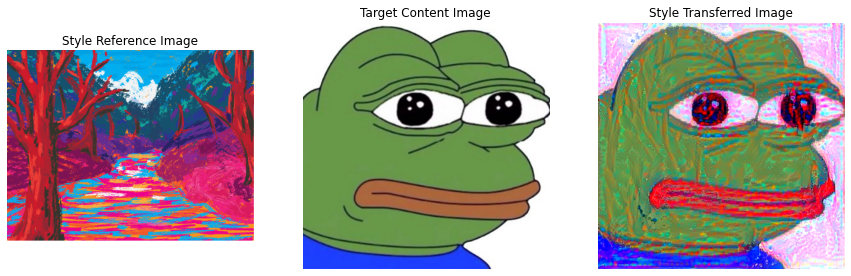

In [9]:
## DISPLAY STYLE TRANSFERRED IMAGE

style_ref_img = Image.open(style_reference_image_path)
original_size = np.array(style_ref_img.size)
scale_factor = img_height / original_size[1]
newsize = original_size*scale_factor
newsize = newsize.astype('int')
style_ref_img = style_ref_img.resize(newsize)

f, ax = plt.subplots(1, 3)
ax[0].set_title('Style Reference Image')
ax[0].axis('off')
ax[0].imshow(style_ref_img)


target_img = Image.open(target_image_path)
original_size = np.array(target_img.size)
scale_factor = img_height / original_size[1]
newsize = original_size*scale_factor
newsize = newsize.astype('int')
target_img = target_img.resize(newsize)
ax[1].set_title('Target Content Image')
ax[1].axis('off')
ax[1].imshow(target_img)


styletransfered_image_path = os.path.join(cwd, "nst_imgs", "my_result_at_iteration_19.png")
final_img = Image.open(styletransfered_image_path)
ax[2].set_title('Style Transferred Image')
ax[2].axis('off')
ax[2].imshow(final_img)

f.set_figheight(15)
f.set_figwidth(15)

plt.show()